In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, utils, layers, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import datetime
from tensorflow.keras.regularizers import L2
from tensorflow.keras.mixed_precision import set_global_policy

# Set the global mixed precision policy to 'mixed_float16'
set_global_policy('mixed_float16')

# Set up log directory for TensorBoard
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Create TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, 
    histogram_freq=1,  
    write_graph=True,  
    write_images=True,  
    profile_batch='500,520')  

2024-10-18 22:23:47.768381: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-10-18 22:23:47.768389: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-10-18 22:23:47.768517: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Using 17400 files for validation.


2024-10-18 22:23:48.910035: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-18 22:23:48.910063: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-18 22:23:48.910071: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-18 22:23:48.910083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-18 22:23:48.910098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-10-18 22:23:49.167995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


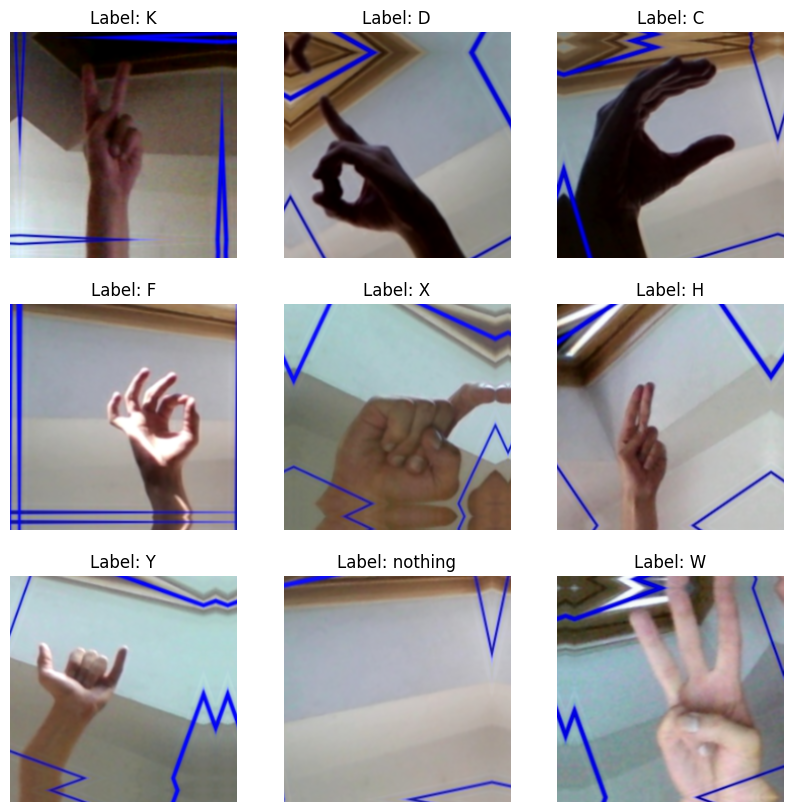

In [2]:
imgSize = 224
batchSize = 512
basePath = os.getcwd()
dataPath = os.path.join(basePath, 'data/asl_alphabet_train')

dsTrain, dsVal = utils.image_dataset_from_directory(
    dataPath,
    image_size = (imgSize,imgSize),
    batch_size = batchSize,
    label_mode='categorical',
    validation_split=0.2,
    subset='both',
    seed=123
)
class_names = dsTrain.class_names
steps_per_epoch = math.ceil(69600 / batchSize)  # Adjust based on your dataset size
validation_steps = math.ceil(17400 / batchSize)  # Adjust as needed

augmentation = Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomFlip("horizontal"),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),
])
rescaling = layers.Rescaling(1./255)

# Apply augmentations and preprocessing for training
def preprocess_train(x, y):
    x = rescaling(augmentation(x, training=True))  # Apply augmentation + rescaling
    return x, y

# Preprocess validation dataset
def preprocess_val(x, y):
    x = rescaling(x)  # Only rescaling for validation
    return x, y

# Apply preprocessing and optimizations to the datasets
dsTrain = dsTrain.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
dsVal = dsVal.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

# Cache datasets and prefetch for better performance
dsTrain = dsTrain.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
dsVal = dsVal.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

dsIter = iter(dsTrain)

augmentedImage, labels = next(dsIter)
augmentedImage = tf.cast(augmentedImage, tf.float32)
plt.figure(figsize=(10, 10))

for i in range(9):  # Display 9 augmented images
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmentedImage[i].numpy())  # Convert tensor to NumPy array and display
    class_index = np.argmax(labels[i].numpy())
    class_name = class_names[class_index]
    plt.title(f"Label: {class_name}")
    plt.axis('off')  # Turn off axis labels for cleaner visualization
    
plt.show()


In [3]:
model = Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(imgSize, imgSize, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(29, activation='softmax')
])

model.summary()

/Users/zixu/miniforge3/envs/dl-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,172,701 (42.62 MB)

 Trainable params: 11,172,701 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:


# Update learning rate
opt = optimizers.Adam(learning_rate=0.001)  # Lower learning rate

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(
    dsTrain.repeat(),
    steps_per_epoch=steps_per_epoch,
    validation_data=dsVal.repeat(),
    validation_steps=validation_steps,
    epochs=20,  # Increase epochs
    callbacks=[early_stopping]
)

Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.0936 - loss: 3.2139 - val_accuracy: 0.2866 - val_loss: 2.3711
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.3242 - loss: 2.2276 - val_accuracy: 0.5214 - val_loss: 1.5682
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.4915 - loss: 1.6358 - val_accuracy: 0.6248 - val_loss: 1.1763
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.5931 - loss: 1.2654 - val_accuracy: 0.7121 - val_loss: 0.9256
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.6727 - loss: 1.0135 - val_accuracy: 0.7731 - val_loss: 0.7188
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.7273 - loss: 0.8415 - val_accuracy: 0.7904 - val_loss: 0.6686
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.7701 - loss: 0.7052 - val_accuracy: 0.8141 - val_loss: 0.5865
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.7927 - loss: 0.6319 - val_accu

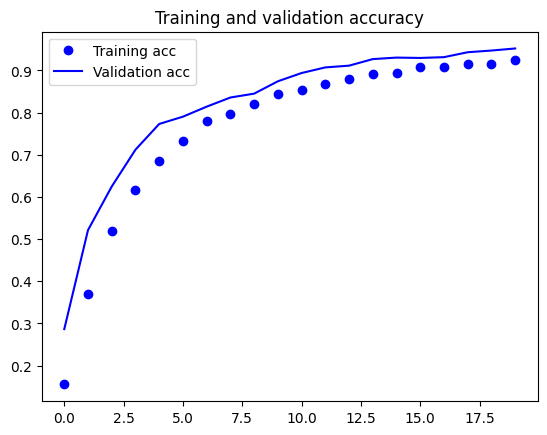

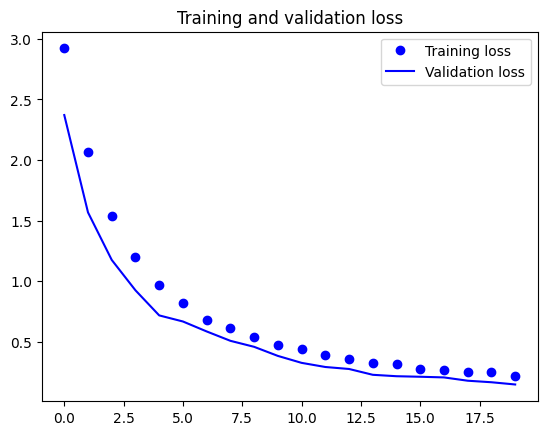

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [3]:
model2 = Sequential([
    layers.Conv2D(32, 3, kernel_initializer='he_normal', input_shape=(224, 224, 3)),
    layers.LeakyReLU(alpha=0.1),  # LeakyReLU activation
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, kernel_initializer='he_normal'),
    layers.LeakyReLU(alpha=0.1),  # LeakyReLU activation
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, kernel_initializer='he_normal'),
    layers.LeakyReLU(alpha=0.1),  # LeakyReLU activation
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, 3, kernel_initializer='he_normal'),
    layers.LeakyReLU(alpha=0.1),  # LeakyReLU activation
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    
    layers.Dense(512, kernel_regularizer=L2(0.01)),  # Add L2 regularization
    layers.LeakyReLU(alpha=0.1),  # LeakyReLU for the dense layer
    
    layers.Dense(128, kernel_regularizer=L2(0.01)),
    layers.LeakyReLU(alpha=0.1),  # LeakyReLU for the dense layer
    layers.Dropout(0.5),
    
    layers.Dense(29, activation='softmax')  # Output layer for 29 classes
])

model2.summary()

/Users/zixu/miniforge3/envs/dl-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/zixu/miniforge3/envs/dl-env/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,332,701 (73.75 MB)

 Trainable params: 19,332,701 (73.75 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Stop training early if validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model during training
checkpoint = ModelCheckpoint(basePath+'/best_model.keras', monitor='val_loss', save_best_only=True)
opt2 = optimizers.Adam(learning_rate=0.0001)
# Compile and fit your model
model2.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(
    dsTrain.repeat(),
    validation_data=dsVal.repeat(),
    epochs=50,
    callbacks=[reduce_lr, early_stopping, checkpoint, tensorboard_callback],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.0581 - loss: 13.0930 - val_accuracy: 0.2499 - val_loss: 6.9654 - learning_rate: 1.0000e-04
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.1767 - loss: 6.4662 - val_accuracy: 0.4441 - val_loss: 4.5061 - learning_rate: 1.0000e-04
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.2864 - loss: 4.6354 - val_accuracy: 0.5486 - val_loss: 3.3982 - learning_rate: 1.0000e-04
Epoch 4/50
 91/136 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - accuracy: 0.3632 - loss: 3.7766

2024-10-18 22:38:00.422662: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-10-18 22:38:00.423028: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


112/136 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.3662 - loss: 3.7502

2024-10-18 22:38:34.542055: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-10-18 22:38:34.648100: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-10-18 22:38:34.651182: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: logs/fit/20241018-222347/plugins/profile/2024_10_18_22_38_34/TANs-MacBook-Pro.local.xplane.pb


136/136 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.3697 - loss: 3.7200 - val_accuracy: 0.6471 - val_loss: 2.7556 - learning_rate: 1.0000e-04
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.4357 - loss: 3.1692 - val_accuracy: 0.6846 - val_loss: 2.3466 - learning_rate: 1.0000e-04
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.4911 - loss: 2.7722 - val_accuracy: 0.7422 - val_loss: 2.0517 - learning_rate: 1.0000e-04
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.5422 - loss: 2.4959 - val_accuracy: 0.7710 - val_loss: 1.8487 - learning_rate: 1.0000e-04
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.5802 - loss: 2.2795 - val_accuracy: 0.8028 - val_loss: 1.6765 - learning_rate: 1.0000e-04
Epoch 9/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.6215 - loss: 2.0884 - val_accuracy: 0.7991 - val_loss: 1.6032 - learning_rate: 1.0000e-04
Epoch 10/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.6

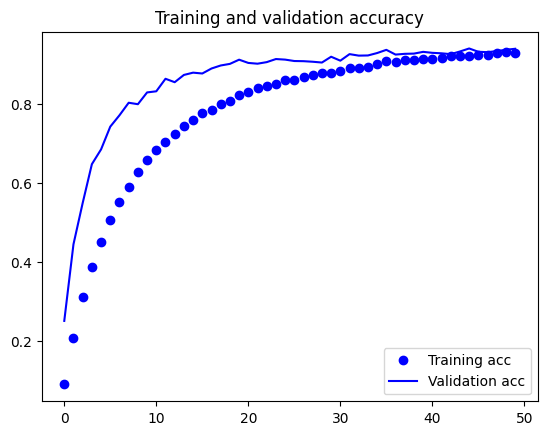

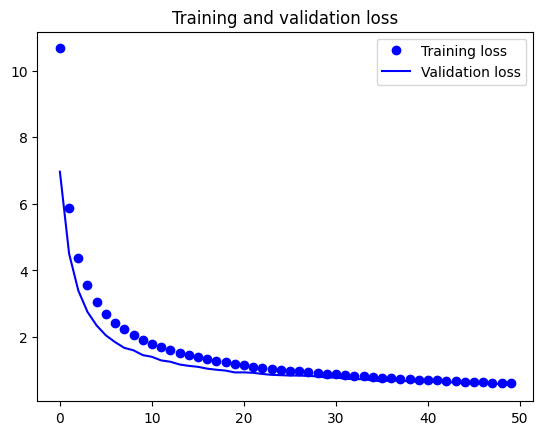

Best model was saved at epoch 50
Accuracy at the best epoch: 92.83%
Validation Loss at the best epoch: 0.5778
Validation Accuracy at the best epoch: 93.95%


In [16]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

best_epoch = np.argmin(val_loss) + 1
print(f"Best model was saved at epoch {best_epoch}")
print(f"Accuracy at the best epoch: {acc[best_epoch - 1]*100:.2f}%")
print(f"Validation Loss at the best epoch: {val_loss[best_epoch - 1]:.4f}")
print(f"Validation Accuracy at the best epoch: {val_acc[best_epoch - 1]*100:.2f}%")

In [9]:
from tensorflow.keras.preprocessing import image
# Path to the test images
test_images_dir = os.path.join(basePath, 'data/asl_alphabet_test')

# List of all test images
test_image_files = os.listdir(test_images_dir)

# Load the best model
best_model = tf.keras.models.load_model(os.path.join(basePath, 'best_model.keras'))

# Iterate through each test image
for img_file in test_image_files:
    img_path = os.path.join(test_images_dir, img_file)
    
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(imgSize, imgSize))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale to [0, 1]

    # Predict the class
    predictions = best_model.predict(img_array)
    predicted_class = np.argmax(predictions)
    
    print(f"Image: {img_file}, Predicted class: {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Image: F_test.jpg, Predicted class: F
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Image: G_test.jpg, Predicted class: G
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Image: L_test.jpg, Predicted class: L
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Image: M_test.jpg, Predicted class: M
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Image: R_test.jpg, Predicted class: R
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Image: S_test.jpg, Predicted class: S
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Image: X_test.jpg, Predicted class: X
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Image: Y_test.jpg, Predicted class: Y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Image: U_test.jpg, Predicted class: U
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Image: T_test.jpg, Predicted class: T
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Image: A_test.jpg, Predicted class: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Image: K_test.jpg, Predicted class: K
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Image: J_test.jpg, Predicted class: J
1/1 ━━━━━━━━━━━━━━━━━━━